# Extracting Physics Using the Unscented Kalman Filter

Now that we have generated data up through phase 3, we are ready to extract best estimate physics parameters from the particle trajectories. We won't go into to much detail here other than to say that the core priciple is to minimize the intial parameters used to solve the differential equations describing the motion of the particles in the gas (including energy loss effects). This can be rather complicated. To try and make this problem tractable, we use the Unscented Kalman Filter from filterpy. Kalman filters are a whole area of research; we use the Unscented filter because it is well suited to non-linear systems.

First, all of our imports

In [11]:
import sys
sys.path.append('..')
from pcutils.core.config import load_config
from pcutils.core.workspace import Workspace
from pcutils.core.clusterize import ClusteredCloud
from pcutils.core.estimator import Direction
from pcutils.core.particle_id import load_particle_id
from pcutils.core.nuclear_data import NuclearDataMap
from pcutils.core.target import Target
from pcutils.core.point_cloud import PointCloud
from pcutils.core.solver_kalman import apply_kalman_filter, QBRHO_2_P, Guess
from pcutils.core.kalman_args import set_kalman_args

import polars as pl
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt
from scipy import constants

Now, as usual, we load our configuration

In [12]:
config = load_config('../config.json')
ws = Workspace(config.workspace)
nuc_map = ws.get_nuclear_map()
pid = load_particle_id(config.solver.particle_id_path, nuc_map)
target = Target(config.solver.gas_data_path, nuc_map)

density:  6.567773654331344e-05
Material: <sup>2</sup>H<sub>2</sub>


Notice here we've loaded not only our workspace but also our paritcle ID data and a target. These are important! Now that we're doing physics we need to pick slices of data that correspond to specific particles so that we can select the appropriate charge and mass. The target allows us to calculate energy loss.

Now we load up our cluster data as well as our estimates from phase 3.

In [13]:
run_number = 4
cluster_file = h5.File(ws.get_cluster_file_path(run_number))
estimate_df = pl.scan_parquet(ws.get_estimate_file_path_parquet(run_number))
estimate_gated = estimate_df.filter(pl.struct(['dEdx', 'brho']).map(pid.cut.is_cols_inside)).collect().to_dict()
cluster_group = cluster_file['cluster']
nrows = len(estimate_gated['event'])
row = np.random.randint(0, nrows)
#row = 2510
print(f'row: {row}')
event = estimate_gated['event'][row]
cluster_index = estimate_gated['cluster_index'][row]
print(f'event: {event}')
print(f'cluster index: {cluster_index}')
event_group = cluster_group[f'event_{event}']
local_cluster = event_group[f'cluster_{cluster_index}']
print(f'Direction: {estimate_gated["direction"][row]}')
cluster = ClusteredCloud()
cluster.label = local_cluster.attrs['label']
cluster.point_cloud = PointCloud()
cluster.point_cloud.load_cloud_from_hdf5_data(local_cluster['cloud'][:].copy(), event)
# Rescale to m
cluster.point_cloud.cloud[:, :3] *= 0.001

row: 754
event: 5763
cluster index: 1
Direction: 0


As per usual we've selected a random cluster to look at. Now we create a Guess from our estimated parameters. We also handle flipping the data if the direction is backwards (>90 degrees lab).

In [14]:
guess = Guess()
guess.brho = estimate_gated['brho'][row]
guess.polar = estimate_gated['polar'][row]
guess.azimuthal = estimate_gated['azimuthal'][row]
#again rescale to meters
guess.vertex_x = estimate_gated['vertex_x'][row] * 0.001
guess.vertex_y = estimate_gated['vertex_y'][row] * 0.001
guess.vertex_z = estimate_gated['vertex_z'][row] * 0.001
guess.direction = Direction(estimate_gated['direction'][row])
if guess.direction is Direction.BACKWARD:
    np.flip(cluster.point_cloud.cloud, axis=0)

Now we pass the extra filter arguments to a special class.

In [15]:
Bfield = -1.0 * config.detector.magnetic_field
Efield = -1.0 * config.detector.electric_field
set_kalman_args(target, pid.nucleus, Bfield, Efield)

Annnnnd, then we run the Unscented Kalman Filter!

In [16]:
trajectory, covariances = apply_kalman_filter(cluster.point_cloud.cloud[:,:3], guess)

The filter returns to us the filtered, smoothed trajectory and the covariances. In principle, this is the best fit of our equations to the data. Now we can plot the trajectory against the data, as shown below

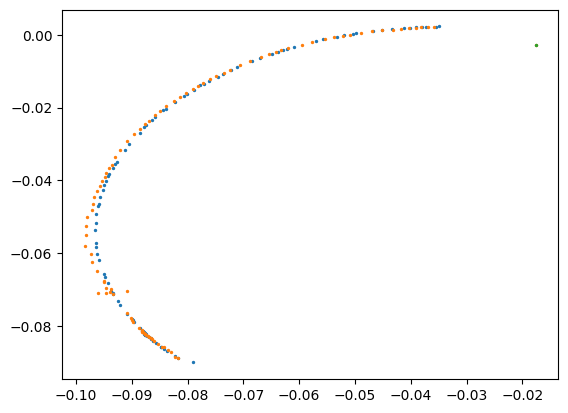

In [17]:
plt.scatter(cluster.point_cloud.cloud[:, 0], cluster.point_cloud.cloud[:, 1].copy(), s=2, label='data')
plt.scatter(trajectory[:, 0], trajectory[:, 1], s=2, label='filter')
plt.scatter(trajectory[0, 0], trajectory[0, 1], s=2, label='filter 0')


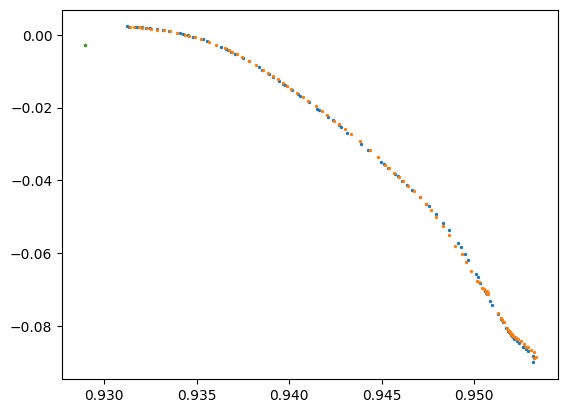

In [18]:
plt.scatter(cluster.point_cloud.cloud[:, 2], cluster.point_cloud.cloud[:, 1], s=2, label='data')
plt.scatter(trajectory[:, 2], trajectory[:, 1], s=2, label='filter')
plt.scatter(trajectory[0, 2], trajectory[0, 1], s=2, label='filter 0')


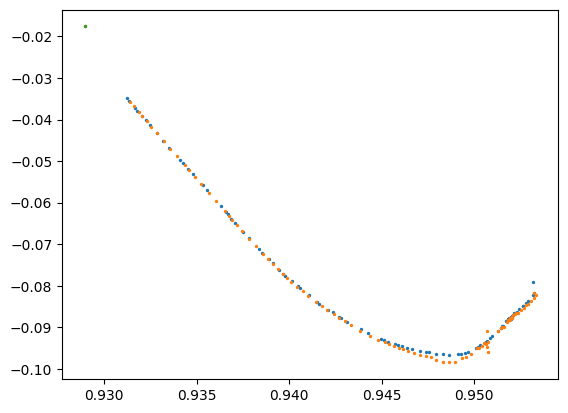

In [19]:
plt.scatter(cluster.point_cloud.cloud[:, 2], cluster.point_cloud.cloud[:, 0], s=2, label='data')
plt.scatter(trajectory[:, 2], trajectory[:, 0], s=2, label='filter')
plt.scatter(trajectory[0, 2], trajectory[0, 0], s=2, label='filter 0')

We can also compare the our original guess of the initial position to the trajetory estimated initial position (as well as energy and angles)

In [20]:
print(f'Initial guess: {guess}')
buest_guess = Guess()
buest_guess.polar = np.arctan2(np.linalg.norm(trajectory[0, 3:5]), trajectory[0, 5])
buest_guess.azimuthal = np.arctan2(trajectory[0, 4], trajectory[0, 3])
if buest_guess.azimuthal < 0:
    buest_guess.azimuthal += np.pi * 2.0
buest_guess.vertex_x = trajectory[0, 0]
buest_guess.vertex_y = trajectory[0, 1]
buest_guess.vertex_z = trajectory[0, 2]
best_momentum = pid.nucleus.mass * (np.linalg.norm(trajectory[0, 3:]) / constants.speed_of_light)
buest_guess.brho = best_momentum / (QBRHO_2_P * pid.nucleus.Z)
print(f'Best guess: {buest_guess}')

Initial guess: Guess(vertex_x=-0.007718749275526797, vertex_y=-0.010102947485517213, vertex_z=0.9269814498162326, brho=0.16298444693720168, polar=1.3444295475329269, azimuthal=2.4893443723319355, direction=<Direction.FORWARD: 0>)
Best guess: Guess(vertex_x=-0.01762424956201347, vertex_y=-0.0028039842895144435, vertex_z=0.9289491690452323, brho=0.16924153099371886, polar=1.3547185456932638, azimuthal=2.494666299350975, direction=-1)


Now we have a best estimate for the physics from this particular cluster, using the Kalman filter!